In [1]:
import tensorflow as tf
import tools.datasets.mnist3 as mnist_tools
import tools.datasets.mnistm as mnistm_tools 
import tools.semisup as semisup
import numpy as np
import architectures as arch
from functools import partial

import tools.visualization as vis
import tools.updated_semisup as up

%load_ext autoreload
%autoreload 2

import sys

mnist_train_images, mnist_train_labels = mnist_tools.get_data('train')
mnist_test_images, mnist_test_labels = mnist_tools.get_data('test')
mnistm_train_images, mnistm_train_labels = mnistm_tools.get_data('train')
mnistm_test_images, mnistm_test_labels = mnistm_tools.get_data('test')

/home/frankzl/.envs/env36-ml/.venv/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


Extracting /home/frankzl/datasets/mnist//train-images-idx3-ubyte.gz
Extracting /home/frankzl/datasets/mnist//train-labels-idx1-ubyte.gz
Extracting /home/frankzl/datasets/mnist//t10k-images-idx3-ubyte.gz
Extracting /home/frankzl/datasets/mnist//t10k-labels-idx1-ubyte.gz


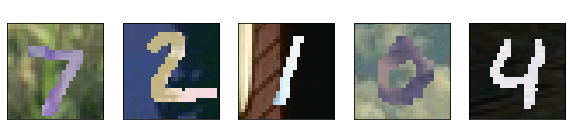

In [2]:
vis.imshow(mnistm_test_images[0:5], channels=3, imgwidth=28)

In [3]:
# labeled samples used per class
# sup_per_class = 10
sup_per_class = 1280
sup_seed = -1
# labeled samples per class per batch
sup_per_batch = 100
# unlabeled samples per batch
unsup_batch_size = 1000
unsup_samples = -1

learning_rate = 1e-4
decay_steps = 9000
decay_factor = 0.33
logit_weight = 1.0

max_steps = 2000
eval_interval = 500

seed = 1

IMAGE_SHAPE = mnist_tools.IMAGE_SHAPE
NUM_LABELS = mnist_tools.NUM_LABELS

# [10 (classes), 10 (samples), 28, 28, 1]
sup_by_label = semisup.sample_by_label(mnist_train_images, mnist_train_labels,
                        sup_per_class, NUM_LABELS, seed)

visit_weight_envelope = "linear"
visit_weight = 0.6
visit_weight_envelope_steps = 1
visit_weight_envelope_delay = 500

walker_weight_envelope = "linear"
walker_weight = 0.6
walker_weight_envelope_steps = 1
walker_weight_envelope_delay = 500

TARGET_SHAPE = mnistm_tools.IMAGE_SHAPE
TEST_SHAPE   = TARGET_SHAPE

image_shape = IMAGE_SHAPE
new_shape   = TARGET_SHAPE
emb_size    = 128

sampled_unsup_images = mnistm_train_images
sampled_unsup_labels = mnistm_train_labels

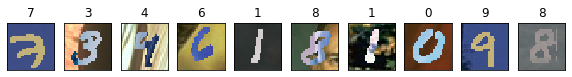

In [4]:
vis.imshow(sampled_unsup_images[:10], labels=sampled_unsup_labels[:10], channels=3, imgwidth=28, num_row=10)

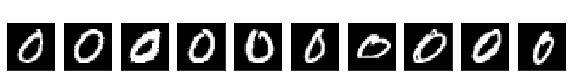

In [5]:
vis.imshow( (sup_by_label[0])[:10], channels=3, imgwidth=28, num_row=10)

In [6]:
from ipywidgets import IntProgress, Layout
from train import apply_envelope
store_dir = "logs/training/mnist-mnistm-06/model"
graph = tf.Graph()

with graph.as_default():
    
    unsup_data = up.create_input(sampled_unsup_images, sampled_unsup_labels, unsup_batch_size)
    unsup_it   = unsup_data.make_initializable_iterator()
    
    t_unsup_images,t_unsup_labels = unsup_it.get_next()
    
    sup_data,sup_label = up.create_per_class_inputs_v2(sup_by_label, sup_per_batch)
    sup_it             = sup_data.repeat().make_one_shot_iterator()
    sup_it_label       = sup_label.repeat().make_one_shot_iterator()
    
    # Apply augmentation
    def _random_invert(inputs, _):
        randu = tf.random_uniform(
            shape=[sup_per_batch * NUM_LABELS], minval=0.,
            maxval=1.,
            dtype=tf.float32)
        randu = tf.cast(tf.less(randu, 0.5), tf.float32)
        randu = tf.expand_dims(randu, 1)
        randu = tf.expand_dims(randu, 1)
        randu = tf.expand_dims(randu, 1)
        inputs = tf.cast(inputs, tf.float32)
        return tf.abs(inputs - 255 * randu)

    augmentation_function = _random_invert
    
    model_func = partial(
        arch.svhn_model,
        new_shape=new_shape,
        augmentation_function=augmentation_function,
        img_shape=image_shape,
        emb_size=emb_size
    )
    
    model = semisup.SemisupModel(model_func, NUM_LABELS, IMAGE_SHAPE,
                                 test_in=tf.placeholder(np.float32, [None] + TEST_SHAPE, 'test_in')
                                )
    
    t_sup_images, t_sup_labels = tf.concat( sup_it.get_next(), 0), tf.concat( sup_it_label.get_next(), 0)
    
    t_sup_emb   = model.image_to_embedding(t_sup_images)
    t_unsup_emb = model.image_to_embedding(t_unsup_images)
    
    t_sup_logit = model.embedding_to_logit(t_sup_emb)
    
    visit_weight = apply_envelope(
        type = visit_weight_envelope,
        step = model.step,
        final_weight = visit_weight,
        growing_steps = visit_weight_envelope_steps,
        delay = visit_weight_envelope_delay
    )
    
    walker_weight = apply_envelope(
        type = walker_weight_envelope,
        step = model.step,
        final_weight = walker_weight,
        growing_steps = walker_weight_envelope_steps,
        delay = walker_weight_envelope_delay
    )
    
    tf.summary.scalar("Weights_Visit", visit_weight)
    tf.summary.scalar("Weight_Walker", walker_weight)
    
    model.add_logit_loss(t_sup_logit, t_sup_labels, weight=logit_weight)
    
    #model.add_semisup_loss(t_sup_emb, t_unsup_emb, t_sup_labels, visit_weight=visit_weight, walker_weight=walker_weight)
    equality_matrix = tf.equal(tf.reshape(t_sup_labels, [-1, 1]), t_sup_labels)
    equality_matrix = tf.cast(equality_matrix, tf.float32)
    p_target = (equality_matrix / tf.reduce_sum(
        equality_matrix, [1], keepdims=True))

    match_ab = tf.matmul(t_sup_emb, t_unsup_emb, transpose_b=True, name='match_ab')
    p_ab = tf.nn.softmax(match_ab, name='p_ab')
    p_ba = tf.nn.softmax(tf.transpose(match_ab), name='p_ba')
    p_aba = tf.matmul(p_ab, p_ba, name='p_aba')

    model.create_walk_statistics(p_aba, equality_matrix)
    
    loss_aba = tf.losses.softmax_cross_entropy(
        p_target,
        tf.log(1e-8 + p_aba),
        weights=walker_weight,
        scope='loss_aba')
    model.add_visit_loss(p_ab, visit_weight)

    mab_dt, pab_dt, paba_dt, semb_dt, uemb_dt = tf.gradients([loss_aba], [match_ab, p_ab, p_aba, t_sup_emb, t_unsup_emb])
    
    tf.summary.scalar('Loss_aba', loss_aba)
    
    t_learning_rate = tf.train.exponential_decay(
        learning_rate,
        model.step,
        decay_steps,
        decay_factor,
        staircase = True
    )
    
    train_op = model.create_train_op(t_learning_rate)
    summary_op = tf.summary.merge_all()
    
    summary_writer = tf.summary.FileWriter(store_dir, graph)
    
    saver = tf.train.Saver(max_to_keep=30)

---------
Variables: name (type shape) [size]
---------
net/conv1/weights:0 (float32_ref 3x3x3x32) [864, bytes: 3456]
net/conv1/biases:0 (float32_ref 32) [32, bytes: 128]
net/conv1_2/weights:0 (float32_ref 3x3x32x32) [9216, bytes: 36864]
net/conv1_2/biases:0 (float32_ref 32) [32, bytes: 128]
net/conv1_3/weights:0 (float32_ref 3x3x32x32) [9216, bytes: 36864]
net/conv1_3/biases:0 (float32_ref 32) [32, bytes: 128]
net/conv2_1/weights:0 (float32_ref 3x3x32x64) [18432, bytes: 73728]
net/conv2_1/biases:0 (float32_ref 64) [64, bytes: 256]
net/conv2_2/weights:0 (float32_ref 3x3x64x64) [36864, bytes: 147456]
net/conv2_2/biases:0 (float32_ref 64) [64, bytes: 256]
net/conv2_3/weights:0 (float32_ref 3x3x64x64) [36864, bytes: 147456]
net/conv2_3/biases:0 (float32_ref 64) [64, bytes: 256]
net/conv3/weights:0 (float32_ref 3x3x64x128) [73728, bytes: 294912]
net/conv3/biases:0 (float32_ref 128) [128, bytes: 512]
net/conv3_2/weights:0 (float32_ref 3x3x128x128) [147456, bytes: 589824]
net/conv3_2/biases:

In [7]:
import time
import datetime
store_dir
test_images = mnistm_test_images[:2000]
test_labels = mnistm_test_labels[:2000]

In [8]:
from IPython.display import display

max_steps = 1502
f = IntProgress(min=0, max=max_steps, layout= Layout(width="100%")) # instantiate the bar
display(f) # display the bar

sesh = tf.Session(graph = graph, config=tf.ConfigProto(intra_op_parallelism_threads=2, allow_soft_placement=True))

eval_interval = 100

p_aba_list = []
match_ab_list = []
t_sup_emb_list = []
t_unsup_emb_list = []


with sesh as sess:
    
    sess.run(unsup_it.initializer)
    sess.run(tf.global_variables_initializer())
    
    epoch = 0
    
    for step in range(0, max_steps):
        t0 = time.time()
        try:
            loss, _, summaries = sess.run([model.train_loss, train_op, summary_op])
        except tf.errors.OutOfRangeError:
            sess.run(unsup_it.initializer)
            epoch += 1
            
            loss, _, summaries = sess.run([model.train_loss, train_op, summary_op])
           
        f.value = step
        f.description = f"Ep{epoch}:{step}/{max_steps}"
        if (step) % eval_interval == 0:
            
            t1 = time.time()
            print(f"Time left: {datetime.timedelta(seconds=int((t1-t0)*(max_steps-step)))}s")
            
            print('Step: %d' % step)
            test_pred = model.classify(test_images).argmax(-1)
            conf_mtx = semisup.confusion_matrix(test_labels, test_pred, NUM_LABELS)
            test_err = (test_labels != test_pred).mean() * 100
            print(conf_mtx)
            print('Test error: %.2f %%' % test_err)
            print(f'Loss: {loss}')
            print()
    
            test_summary = tf.Summary(
                value=[tf.Summary.Value(
                    tag='Test Err', simple_value=test_err)])
    
            summary_writer.add_summary(summaries, step)
            summary_writer.add_summary(test_summary, step)

            print(f"saving model - step {step}")
            saver.save(sess, store_dir, global_step=model.step)

IntProgress(value=0, layout=Layout(width='100%'), max=1502)

Time left: 6:40:25s
Step: 0
[[  0  42   5   0   2   0   2   6 114   4]
 [  0 125   5   1   0   3   4  23  67   6]
 [  0  87   5   0   1   5   8   7 102   4]
 [  0  80   5   1   1   1   9  17  83  10]
 [  0  31   6   4   3   0   4  15 141  13]
 [  0  45   4   1   2   0   8  11 104   4]
 [  0  43   4   2   2   0   6   6 109   6]
 [  0  60   6   1   1   0   8  41  83   5]
 [  0  53   4   1   3   1   9   8  99  14]
 [  0  35  10   0   1   0  12  16 112   8]]
Test error: 85.60 %
Loss: 2.3436503410339355

saving model - step 0
Time left: 6:48:59s
Step: 100
[[119   0   9   6   8   7  10   3  13   0]
 [  3 110  15   6  31   3   8  15  38   5]
 [  8   1 146  13   8   2   8   7  21   5]
 [  4   3  13 107  11  14   2   8  41   4]
 [  3   0  16   8 113   7  10  12  27  21]
 [  7   0   8  12   5 113   4   1  27   2]
 [  7   2  12   9   9  11 109   4  14   1]
 [  2   0  13  11  13   4   0 122  29  11]
 [ 16   1   6  14   9   4   8  11 111  12]
 [  3   0   8  15  32   9   3  13  27  84]]
Test error: 

In [8]:
all_steps = list(range(1,1502,100))

p_aba_list = []
match_ab_list = []
p_ab_list = []
semb_list = []
uemb_list = []
slabel_list = []
ulabel_list = []

for train_step in all_steps:
    model_checkpoint = f"{store_dir}-{train_step}"

    with tf.Session(graph=graph) as sess:
        
        saver = tf.train.Saver()
        saver.restore(sess, model_checkpoint)
        
        sess.run(unsup_it.initializer)
        
        pab, slabel, ulabel, ab, aba, semb, uemb = sess.run([p_ab, t_sup_labels, t_unsup_labels, match_ab, p_aba, t_sup_emb, t_unsup_emb])
        p_aba_list.append(aba)
        match_ab_list.append(ab)
        p_ab_list.append(pab)
        semb_list.append(semb)
        uemb_list.append(uemb)
        slabel_list.append(slabel)
        ulabel_list.append(ulabel)

INFO:tensorflow:Restoring parameters from logs/training/mnist-mnistm-06/model-1
INFO:tensorflow:Restoring parameters from logs/training/mnist-mnistm-06/model-101
INFO:tensorflow:Restoring parameters from logs/training/mnist-mnistm-06/model-201
INFO:tensorflow:Restoring parameters from logs/training/mnist-mnistm-06/model-301
INFO:tensorflow:Restoring parameters from logs/training/mnist-mnistm-06/model-401
INFO:tensorflow:Restoring parameters from logs/training/mnist-mnistm-06/model-501
INFO:tensorflow:Restoring parameters from logs/training/mnist-mnistm-06/model-601
INFO:tensorflow:Restoring parameters from logs/training/mnist-mnistm-06/model-701
INFO:tensorflow:Restoring parameters from logs/training/mnist-mnistm-06/model-801
INFO:tensorflow:Restoring parameters from logs/training/mnist-mnistm-06/model-901
INFO:tensorflow:Restoring parameters from logs/training/mnist-mnistm-06/model-1001
INFO:tensorflow:Restoring parameters from logs/training/mnist-mnistm-06/model-1101
INFO:tensorflow:

In [9]:
sorted_uemb_list     = []
sorted_match_ab_list = []

from scipy.special import softmax

for idx in range(len(uemb_list)):
    sorted_uemb_list.append(uemb_list[idx][ulabel_list[idx].argsort()])
    sorted_match_ab_list.append(match_ab_list[idx][:,ulabel_list[idx].argsort()])

In [10]:
from ipywidgets import IntSlider, RadioButtons
from IPython.html.widgets import *
import matplotlib.pyplot as plt

def plot_img(array, step):
    if array == 0:
        a = p_aba_list
    elif array == 1:
        a = match_ab_list
    else:
        a = sorted_match_ab_list
            
    fig = plt.figure()
    plt.imshow(a[(step-1)//100])

interact(
    lambda step, array: plot_img(array, step),
    step = IntSlider(
        value=901,
        min=1,
        max=1501,
        step=100,
        description='Train Step',
        continuous_update=True,
        orientation='horizontal',
    ),
    array = RadioButtons(
        options=[('p_aba', 0), ("match_ab", 1), ("sorted_match_ab", 2)],
    )
)

/home/frankzl/.envs/env36-ml/.venv/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


interactive(children=(IntSlider(value=901, description='Train Step', max=1501, min=1, step=100), RadioButtons(…

<function __main__.<lambda>(step, array)>

In [ ]:
idx = 6
my_semb = semb_list[idx]
my_uemb = uemb_list[idx]

embedding_dim = my_semb.shape[1]

reshaped_semb = my_semb.reshape((-1, 1, embedding_dim))
reshaped_uemb = my_uemb.reshape((-1, 1, embedding_dim))

repeat_semb = np.repeat(reshaped_semb, len(reshaped_uemb), axis=1)
repeat_uemb = np.repeat(reshaped_uemb, len(reshaped_semb), axis=1)

uemb_T = np.transpose(repeat_uemb, axes=[1,0,2])

sigma = 10
my_match_ab = np.exp(-(np.linalg.norm(repeat_semb - uemb_T, axis=2)**2)/(2*sigma**2))

from sklearn.utils.extmath import softmax
ab = softmax(my_match_ab)

#plt.imshow(ab@softmax(my_match_ab.T))
plt.imshow(ab)

In [ ]:
with tf.Session(graph=graph) as sess:
    saver = tf.train.Saver()
    
    model_checkpoint = f"{store_dir}-{401}"
    saver.restore(sess, model_checkpoint)
    sess.run(unsup_it.initializer)
    
    semb, uemb, laba, mabgr, pabgr, pabagr, sgr, ugr = sess.run([t_sup_emb, t_unsup_emb, loss_aba, mab_dt, pab_dt, paba_dt, semb_dt, uemb_dt])

In [ ]:
pabagr

In [ ]:
pabgr

In [ ]:
mabgr

In [ ]:
sgr

In [ ]:
mabgr @ uemb

In [ ]:
semb

<Figure size 432x288 with 0 Axes>

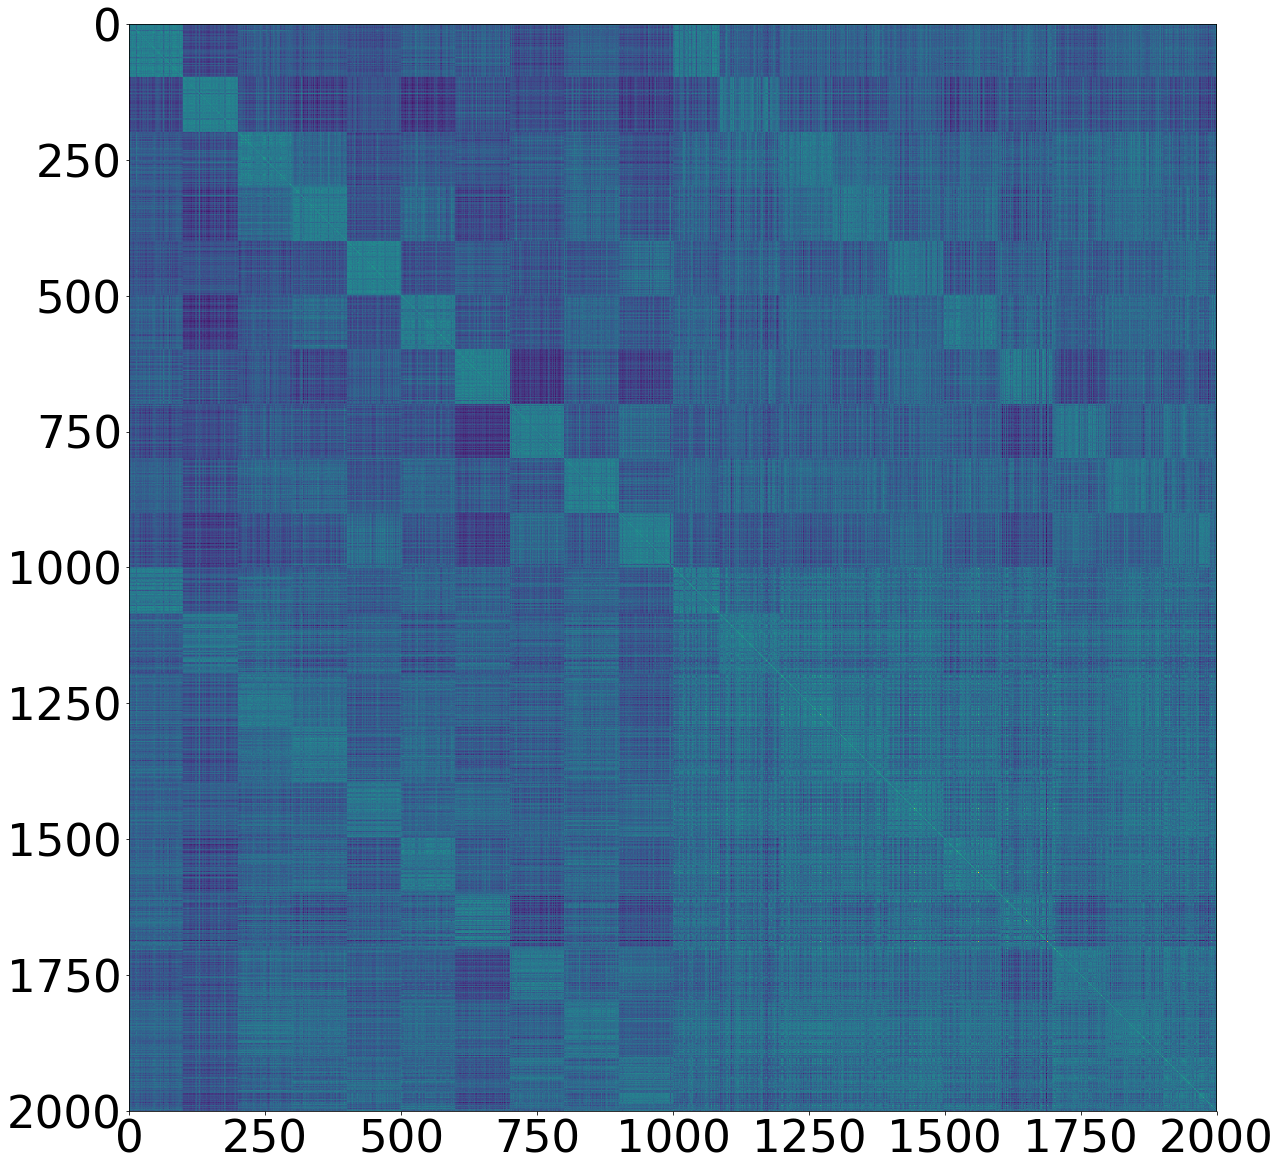

In [23]:
from tools.analyzer import Distance
import tools.analyzer as ana


idx = 7
stacked = np.vstack((semb_list[idx], uemb_list[idx][ulabel_list[idx].argsort()]))

similarity = ana.get_pairwise_distance(
  stacked, 
  Distance.k_dot)

import matplotlib.pyplot as plt
fig = plt.figure()

##plt.imshow(dot_similarity)

plt.figure(figsize=(20,20))
plt.imshow(similarity)

import matplotlib
matplotlib.rcParams.update({'font.size': 45})

plt.savefig("dotsimilarity_mnist_mnistm600.svg")

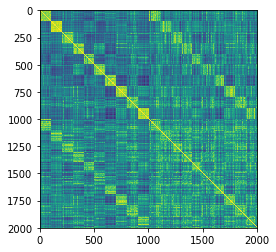

In [13]:
from tools.analyzer import Distance
import tools.analyzer as ana

idx = -1
stacked = np.vstack((semb_list[idx], uemb_list[idx][ulabel_list[idx].argsort()]))

similarity = ana.get_pairwise_distance(
  stacked, 
  Distance.get_gaussian_k(sigma=5))

import matplotlib.pyplot as plt
fig = plt.figure()
plt.imshow(similarity)

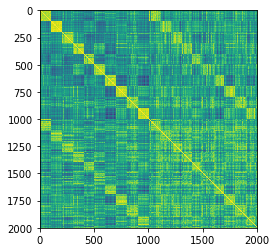

In [14]:
similarity = ana.get_pairwise_distance(
  stacked, 
  Distance.get_gaussian_k(sigma=10))

fig = plt.figure()
plt.imshow(similarity)

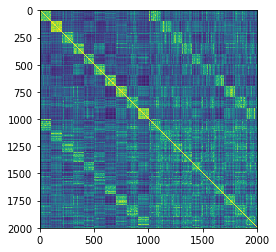

In [17]:
similarity = ana.get_pairwise_distance(
  stacked, 
  Distance.get_gaussian_k(sigma=3.5))

fig = plt.figure()
plt.imshow(similarity)

In [21]:
def get_gradient_info(idx):
    with tf.Session(graph=graph) as sess:
        saver = tf.train.Saver()
        
        model_checkpoint = f"{store_dir}-{idx}"
        saver.restore(sess, model_checkpoint)
        sess.run(unsup_it.initializer)
        
        test_pred = model.classify(test_images).argmax(-1)
        
        uemb, semb, laba, mabgr, pabgr, pabagr, sgr, ugr, target, aba, wweight = sess.run([t_unsup_emb, t_sup_emb, loss_aba, mab_dt, pab_dt, paba_dt, semb_dt, uemb_dt, p_target,p_aba, walker_weight])
    return {
        "unsup_emb": uemb,
        "sup_emb": semb,
        "loss_aba": laba, 
        "match gradient": mabgr,
        "p_ab gradient":pabgr, 
        "p_aba gradient": pabagr, 
        "sup emb gradient": sgr, 
        "unsup emb gradient": ugr,
        "p_target": target,
        "p_aba": aba,
        "walker_weight": wweight
    }

#info401 = get_gradient_info(401)

In [40]:
info601 = get_gradient_info(701)

INFO:tensorflow:Restoring parameters from logs/training/mnist-mnistm-06/model-701


In [41]:
info601['loss_aba']

3.2034812

In [42]:
#info601["p_target"]
total = 0
#for i in range(1000):
#    total += info601["p_target"][i] @ np.log(info601["p_aba"].T)[i]
#- total/1000 * info601["walker_weight"]
- np.mean(np.diag(info601["p_target"] @ np.log(info601["p_aba"].T))) * info601["walker_weight"]

3.2034776

In [29]:
info601["match gradient"] @ info601["unsup_emb"]

array([[ 9.14651609e-05,  9.15910714e-05,  8.03104922e-05, ...,
         8.30413192e-05,  5.55265360e-05,  8.07801698e-05],
       [ 2.41257876e-04,  2.41073853e-04,  1.52545254e-04, ...,
         6.14057499e-05,  2.76851315e-05,  2.15954758e-04],
       [ 2.57608976e-04,  2.56746280e-04,  1.58223236e-04, ...,
         3.12462289e-05, -3.26284426e-05,  2.27679848e-04],
       ...,
       [-2.83868564e-03, -2.80584232e-03, -1.05179963e-03, ...,
         7.13011366e-04, -1.50416419e-03, -2.45042471e-03],
       [ 2.92652519e-04,  2.88765674e-04,  1.62996686e-04, ...,
        -4.96783614e-05,  1.86321849e-04,  2.69482698e-04],
       [-2.53127509e-04, -2.50384328e-04, -6.90433444e-05, ...,
         1.11698064e-04, -7.23188205e-05, -2.26818898e-04]], dtype=float32)

In [27]:
info601["sup emb gradient"]

array([[ 9.1465154e-05,  9.1591100e-05,  8.0310485e-05, ...,
         8.3041312e-05,  5.5526518e-05,  8.0780141e-05],
       [ 2.4125789e-04,  2.4107385e-04,  1.5254531e-04, ...,
         6.1405735e-05,  2.7685130e-05,  2.1595474e-04],
       [ 2.5760903e-04,  2.5674631e-04,  1.5822322e-04, ...,
         3.1246229e-05, -3.2628443e-05,  2.2767982e-04],
       ...,
       [-2.8386854e-03, -2.8058423e-03, -1.0518000e-03, ...,
         7.1301137e-04, -1.5041641e-03, -2.4504247e-03],
       [ 2.9265249e-04,  2.8876564e-04,  1.6299667e-04, ...,
        -4.9678376e-05,  1.8632189e-04,  2.6948270e-04],
       [-2.5312748e-04, -2.5038427e-04, -6.9043344e-05, ...,
         1.1169809e-04, -7.2318820e-05, -2.2681888e-04]], dtype=float32)